## Importing Libraries and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

import re
from tqdm import tqdm

from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import QuantileTransformer

In [3]:
df = pd.read_csv('health.csv')
df.head(4)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,MentalHealth
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  MentalHealth    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.describe(include='all')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,MentalHealth
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


In [6]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
MentalHealth        2
dtype: int64

**Observation:**

    1. There are 11 features and 1 target variable MentalHealth
    2. There are no null values
    3. FastingBS is categorical in nature. Lets convert int to category in data
    4. As max of cholestral is far from 75th percentile. There is a possibility of outlier

In [8]:
df['FastingBS'] = df['FastingBS'].astype('str')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  MentalHealth    918 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 86.2+ KB


**Separating numerical and categorical variables**

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

categorical_cols, numeric_cols

(['Sex',
  'ChestPainType',
  'FastingBS',
  'RestingECG',
  'ExerciseAngina',
  'ST_Slope'],
 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'MentalHealth'])

In [12]:
for feature in categorical_cols:
    print(feature, ' : ', df[feature].unique())

Sex  :  ['M' 'F']
ChestPainType  :  ['ATA' 'NAP' 'ASY' 'TA']
FastingBS  :  ['0' '1']
RestingECG  :  ['Normal' 'ST' 'LVH']
ExerciseAngina  :  ['N' 'Y']
ST_Slope  :  ['Up' 'Flat' 'Down']


In [13]:
def clean_text(text):
    "preprocess text data"
    
    text = str(text).lower()
    text = re.sub(r'\(.*', ' ', text)
    text = text.strip()
    text = re.sub(r'[ -]', '_', text)
    
    return text

In [14]:
for feature in tqdm(categorical_cols):
    df[feature] = df[feature].apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 477.31it/s]


In [15]:
# Take dump of cleaned data
df.to_csv('df_cleaned.csv', index=False)

## Functions

In [17]:
def get_lower_upper_bounds(df, feature):
    """This function returns the upper and lower bound for the numeric feature"""
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [18]:
def get_outlier_values(df, feature, return_bounds=False):

    lower_bound, upper_bound = get_lower_upper_bounds(df,feature)

    outlier_values = sorted(df[feature][(df[feature] < lower_bound)|(df[feature] > upper_bound)].unique())

    if return_bounds:
        return outlier_values, lower_bound, upper_bound
    else:
        return outlier_values

## EDA

### Target Variable

<Axes: xlabel='MentalHealth', ylabel='count'>

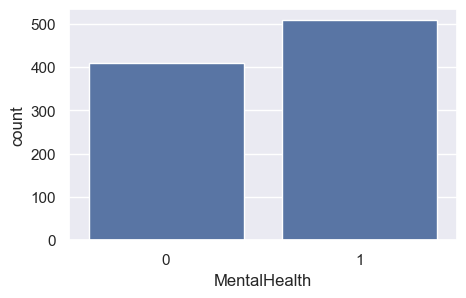

In [21]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='MentalHealth')

**Observation:** Data is almost balanced

### Numeric variables

In [24]:
numeric_cols.remove('MentalHealth')

with open(r'.\dumps\numeric_columns.pkl', 'wb') as f:
    pickle.dump(numeric_cols,f)

In [25]:
df[numeric_cols].nunique()

Age             50
RestingBP       67
Cholesterol    222
MaxHR          119
Oldpeak         53
dtype: int64

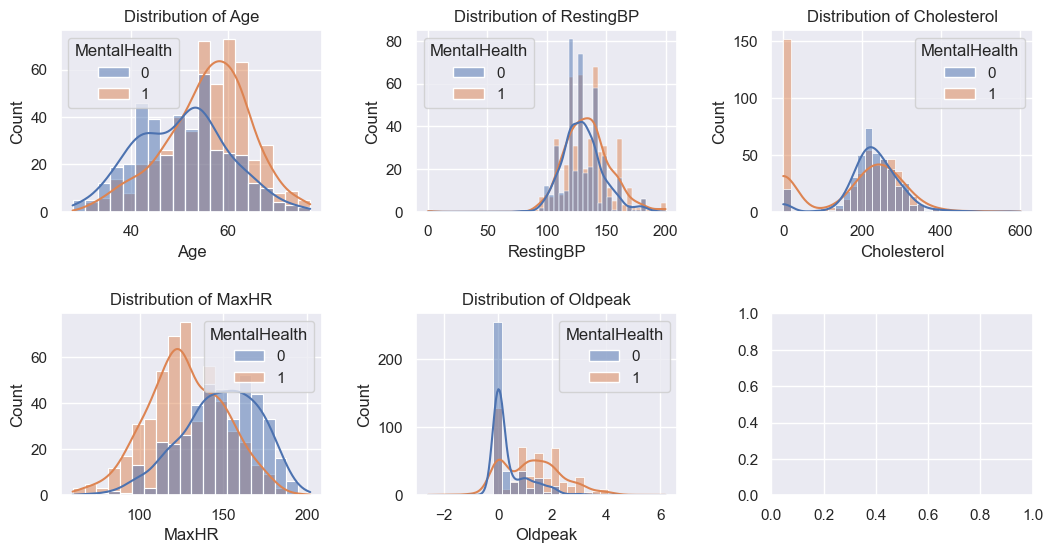

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(11, 6))

axs= axs.flatten()

for i, feature in enumerate(numeric_cols):
    if i >= len(axs):  # Avoid indexing out of bounds
        break
    sns.histplot(data=df, x=feature, hue='MentalHealth', kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")

plt.tight_layout(pad=2.0)
plt.show()

**Observation:**

    1. MentalHealth being '1' is more prevalent over 50
    2. Propbability of MentalHealth being '1' is very high for zero Cholesterol
    3. MentalHealth is '1' for lower MaxHRs
    4. MentalHealth being '1' increases with OldPeak values

**Lets check for outliers**

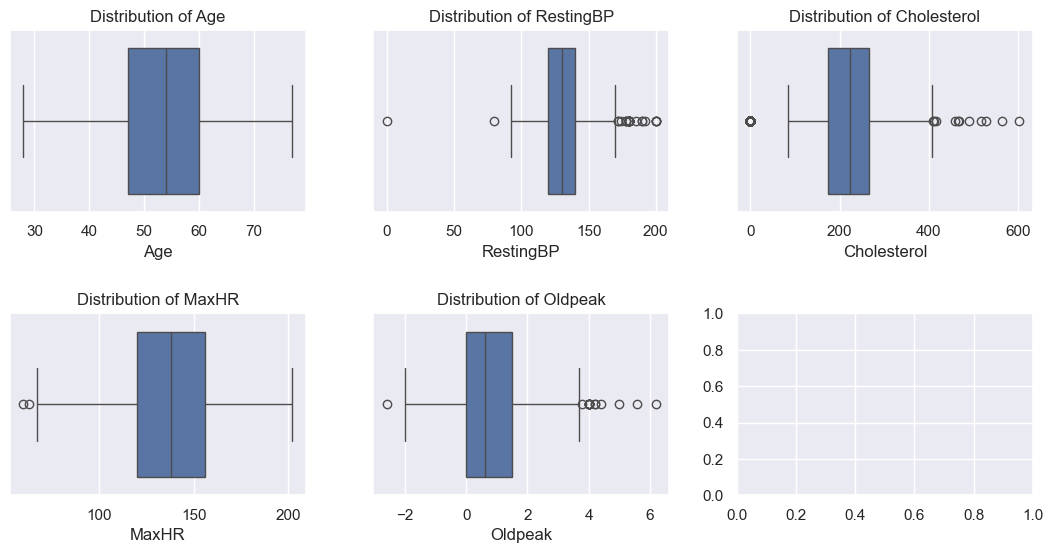

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(11, 6))

# Flatten the axes array for easy indexing
axs = axs.flatten()

for i, feature in enumerate(numeric_cols):
    if i >= len(axs):  # Avoid indexing out of bounds
        break
    sns.boxplot(data=df, x=feature, ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")

plt.tight_layout(pad=2.0)
plt.show()

**Observation:** Feature Age do not have outliers. While other features have some outliers.

**Lets identify the lower and upper bounds for each numeric feature**

In [32]:
outlier_df = []
for feature in numeric_cols:
    outlier_values, lower_bound, upper_bound = get_outlier_values(df, feature, return_bounds=True)
    outlier_df.append({'feature' : feature,
                  'lower_bound' : lower_bound,
                  'upper_bound' : upper_bound,
                  'outlier_values' : outlier_values
                 })
outlier_df = pd.DataFrame(outlier_df)

outlier_df

,feature,lower_bound,upper_bound,outlier_values
0,Age,27.500,79.500,[]
1,RestingBP,90.000,170.000,"[0, 80, 172, 174, 178, 180, 185, 190, 192, 200]"
2,Cholesterol,32.625,407.625,"[0, 409, 412, 417, 458, 466, 468, 491, 518, 52..."
3,MaxHR,66.000,210.000,"[60, 63]"
4,Oldpeak,-2.250,3.750,"[-2.6, 3.8, 4.0, 4.2, 4.4, 5.0, 5.6, 6.2]"


In [33]:
for i in range(95,101,1):
    print(f'{i}th percentile', round(np.percentile(df['Oldpeak'], i),2))

95th percentile 3.0
96th percentile 3.0
97th percentile 3.05
98th percentile 3.6
99th percentile 4.0
100th percentile 6.2


**Observation:**

    1. Age do not have outliers
    2. RestingBP - though values outside the bounds, they are meaningful/valid values. So, lets change the bound values
    3. From domain knowledge, cholesterol level can be binned
    4. MaxHR - they are valid points. Lets change the bounds
    5. Oldpeak - Lets take 99th percentile value as upper bound

**Note**: We are cautiously not deleting the records as we have very less data

In [110]:
lower_upper_bounds = {
    'Age' : [27.5, 79.5],
    'RestingBP' : [80, 200],
    'Cholesterol' : [0, 600],
    'MaxHR' : [60,210],
    'Oldpeak' : [-2.6, 4.0]
}

with open(r'.\dumps\lower_upper_bounds.pkl', 'wb') as f:
    pickle.dump(lower_upper_bounds, f)

In [36]:
df = df[(df['RestingBP'] >= 80) & (df['RestingBP'] <= 200)]
df = df[(df['Oldpeak'] >= -2.6) & (df['Oldpeak'] <= 4.0)]

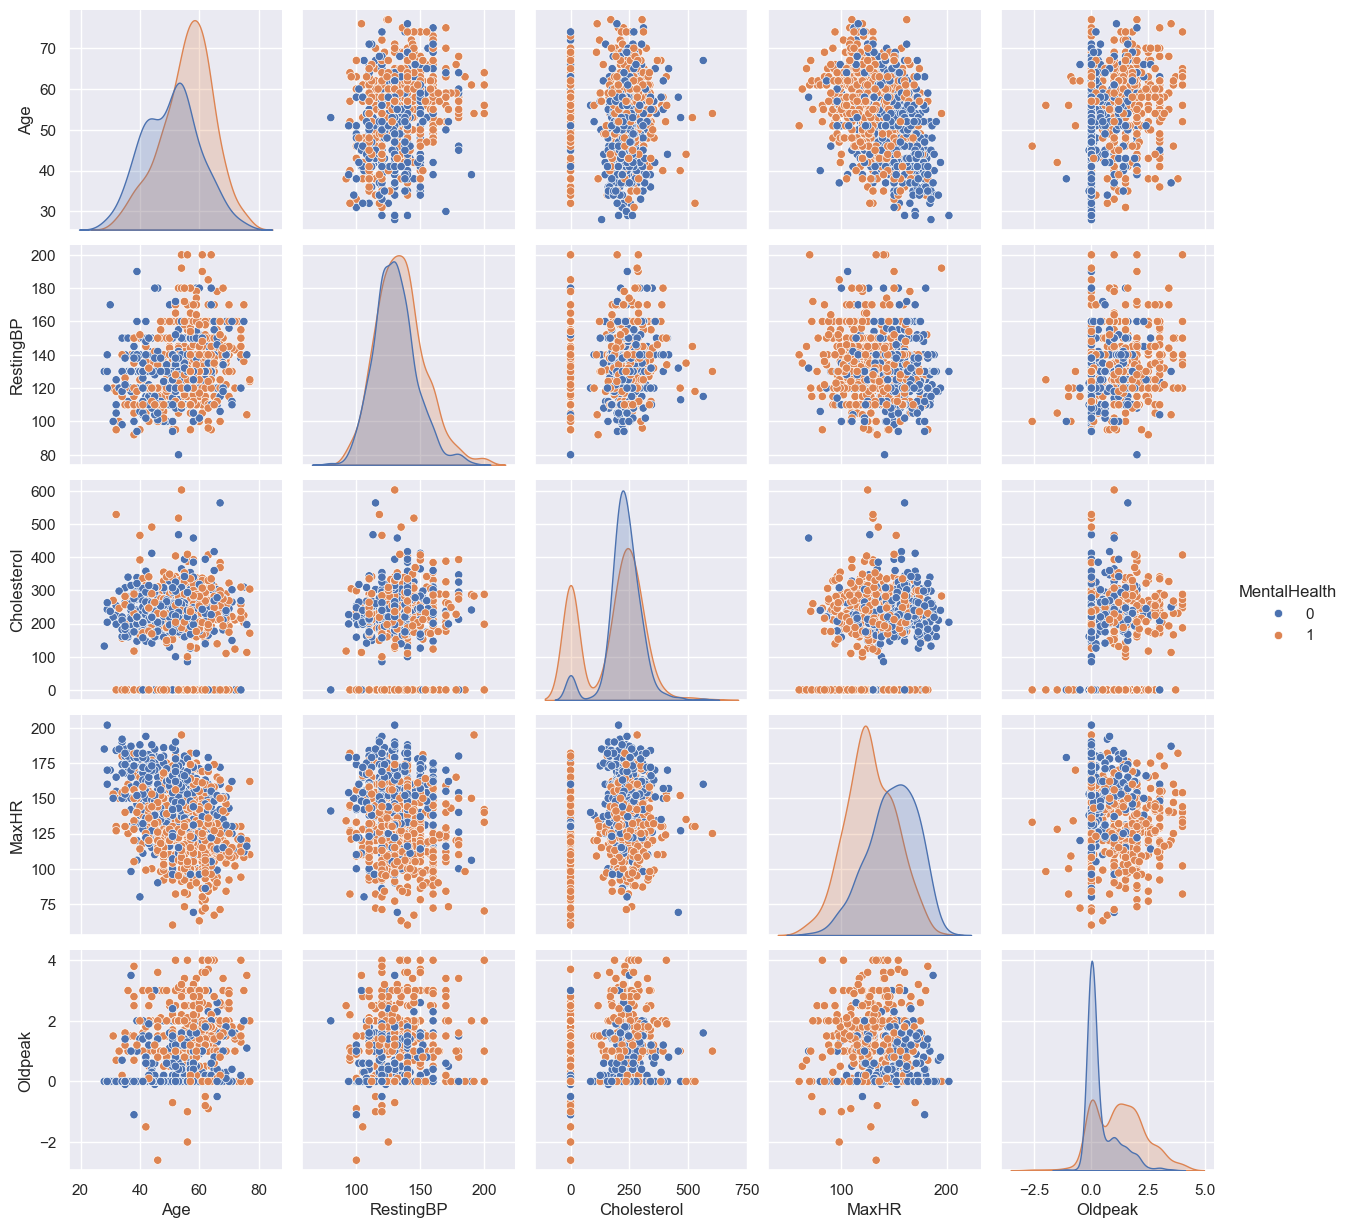

In [37]:
sns.pairplot(df, hue='MentalHealth')

**Correlation between numerical features**

<Axes: >

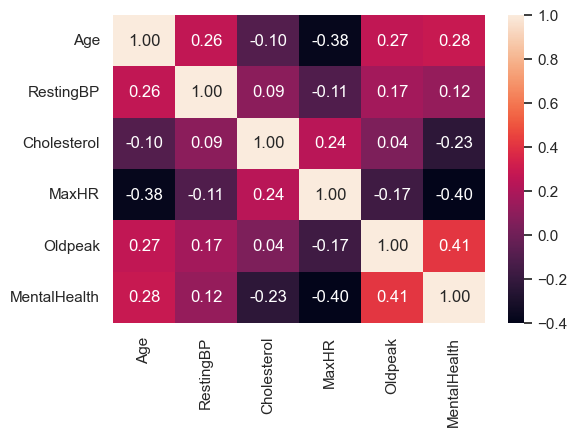

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols + ['MentalHealth']].corr(), annot=True, fmt='.2f')

**Observation:** No strong correlation between numerical features

In [41]:
# Cholesterol Binning
df.loc[(df["Cholesterol"] == 0), "New_Cholesterol_Bin"] = "zero"
df.loc[(df["Cholesterol"] > 0) & (df["Cholesterol"] <= 199), "New_Cholesterol_Bin"] = "low"
df.loc[(df["Cholesterol"] > 199) & (df["Cholesterol"] <= 239), "New_Cholesterol_Bin"] = "medium"
df.loc[(df["Cholesterol"] > 239), "New_Cholesterol_Bin"] = "high"

<Axes: xlabel='New_Cholesterol_Bin', ylabel='count'>

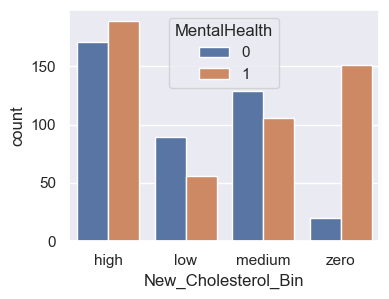

In [42]:
plt.figure(figsize=(4,3))
sns.countplot(data=df, x='New_Cholesterol_Bin', hue='MentalHealth')

**Observation:** Zero Cholesteral has highest risk of mental health

### Categorical Columns

In [82]:
print(categorical_cols)

with open(r'.\dumps\categorical_columns.pkl', 'wb') as f:
    pickle.dump(categorical_cols, f)

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


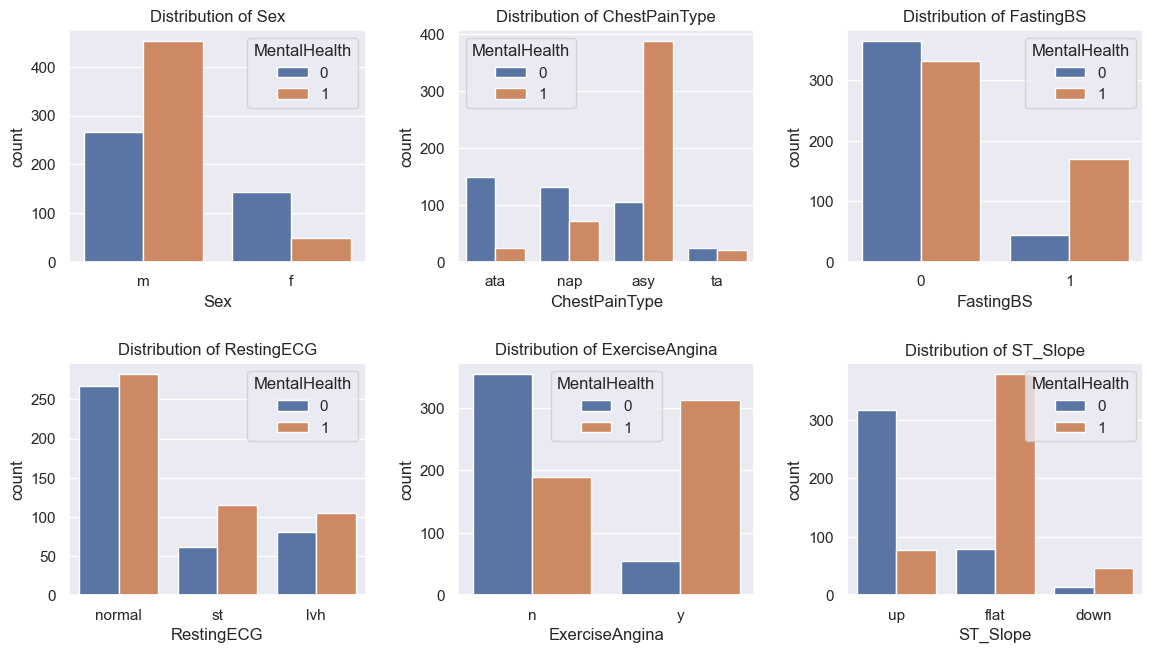

In [96]:
fig, axs = plt.subplots(2,3, figsize=(12,7))

axs = axs.flatten()
for i, feature in enumerate(categorical_cols):
    sns.countplot(data=df, x=feature, hue='MentalHealth', ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")
plt.tight_layout(pad=2.0)

**Observation:**

    1. Male has higher chance of mental health issue
    2. ChestPain type 'asy' has highest risk of mental health issue
    3. The risk is higher if FastingBS is 1
    4. Risk is higher for 'y' Exercise Angina
    5. 'flat' ST_slope has high risk of mental health

**Now lets see statistically if there is significant association of categorical variables with target variable**

In [103]:
results = []
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['MentalHealth'])
    # print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # print(f'Feature: {col}, p-value: {p}')
    results.append({'Feature': col,
                    'p-value': round(p,2)})
pd.DataFrame(results)

,Feature,p-value
0,Sex,0.0
1,ChestPainType,0.0
2,FastingBS,0.0
3,RestingECG,0.0
4,ExerciseAngina,0.0
5,ST_Slope,0.0


Since, the p-value is less than 0.5, we reject the null hypothesis and accept that there is association of categorical features with target variable